In [56]:
import os
import cv2
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import resnet18, ResNet18_Weights, GoogLeNet, GoogLeNet_Weights
from keras import layers

In [64]:
class CustomDataset(Dataset):
    def __init__(self, root, filenames, mode="train"):
        self.image_root = root
        self.filenames = filenames
        self.mode = mode 
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        label_map = {}
        if self.mode == mode:
            #df = pd.read_csv("E:\garypython\drive-download-20230604T142257Z-001\label.csv")
            for i in os.listdir(self.image_root):
                if 'imgN' in i:
                    label_map['{}'.format(i)] = 0
                else:
                    label_map['{}'.format(i)] = 1
            self.labels = [label_map[filename] for filename in self.filenames]

    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, index):
        filename = self.filenames[index]
        image_path = os.path.join(self.image_root, filename)
        image = cv2.imread(image_path)
        image = self.transform(image)
        
        label = self.labels[index]
        return image, label
        
        '''
        if self.mode == mode:
            label = self.labels[index]
            return image, label
        else:
            return image'''

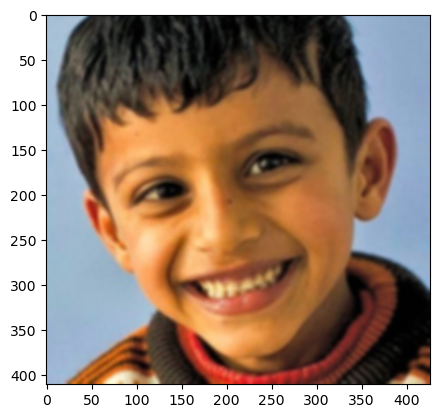

In [65]:
workspace = "E:\garypython\drive-download-20230604T142257Z-001"
train_root_old = os.path.join(workspace, "train")

filenames_old = [filename for filename in os.listdir(train_root_old)]

a = 1
b = 1
for i in os.listdir(train_root_old):
    pt = os.path.join(train_root_old , i)
    if 'Non_Autistic' in i:
        Imges = cv2.imread(pt)
        Imges = cv2.GaussianBlur(Imges, (7, 7), 2)
        cv2.imwrite("E:\garypython\drive-download-20230604T142257Z-001/new_train/imgN.{}.jpg".format(a), Imges)
        a += 1
    else:
        Imges = cv2.imread(pt)
        Imges = cv2.GaussianBlur(Imges, (7, 7), 2)
        cv2.imwrite("E:\garypython\drive-download-20230604T142257Z-001/new_train/imgA.{}.jpg".format(b), Imges)
        b += 1    
    
del filenames_old
gc.collect()

train_root_new = os.path.join(workspace, "new_train")
k = 0
for i in os.listdir(train_root_new):
    pt = os.path.join(train_root_new , i)
    Imges = img.imread(pt)
    plt.imshow(Imges)
    k += 1
    if k > 4:
        break

filenames_new = [filename for filename in os.listdir(train_root_new)]

train_filenames = filenames_new[:int(len(filenames_new)*0.8)]
valid_filenames = filenames_new[int(len(filenames_new)*0.8):]

train_dataset = CustomDataset(train_root_new, train_filenames, mode="new_train")
valid_dataset = CustomDataset(train_root_new, valid_filenames, mode="new_train")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [66]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.vit = models.vision_transformer.vit_b_16(pretrained=True)
        self.classfile = nn.Linear(1000, 2)

    def forward(self, x):
        out = self.vit(x)
        out = self.classfile(out)
        
        return out

In [68]:
device = 'cuda'
num_epoch = 10

model = ClassificationModel()
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

best_accuracy = 0.0
for epoch in range(num_epoch):
    train_loss = 0.0
    correct, total = 0, 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 

        batch_loss = loss(outputs, labels)
        batch_loss.backward() #讓我CUDA不會爆掉
        optimizer.step() #改權重

        train_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()#判讀結果，正確就加1
        total += images.shape[0]
    train_accuracy = correct / total * 100

    valid_loss = 0.0
    correct, total = 0, 0
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
          
        batch_loss = loss(outputs, labels)
        valid_loss += batch_loss.item()
        correct += sum(torch.argmax(outputs, dim=1) == labels).item()
        total += images.shape[0]
    valid_accuracy = correct / total * 100

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), "best_weight.pt")

    print(f"Epoch [{epoch+1}/{num_epoch}] - Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

Epoch [1/10] - Train Loss: 0.4614, Train Accuracy: 78.44%, Valid Loss: 0.9912, Valid Accuracy: 46.85%
Epoch [2/10] - Train Loss: 0.2825, Train Accuracy: 88.48%, Valid Loss: 0.7525, Valid Accuracy: 65.35%
Epoch [3/10] - Train Loss: 0.1878, Train Accuracy: 92.77%, Valid Loss: 0.6268, Valid Accuracy: 73.03%
Epoch [4/10] - Train Loss: 0.1007, Train Accuracy: 96.85%, Valid Loss: 1.0225, Valid Accuracy: 62.60%
Epoch [5/10] - Train Loss: 0.0427, Train Accuracy: 99.06%, Valid Loss: 1.0141, Valid Accuracy: 67.72%
Epoch [6/10] - Train Loss: 0.0259, Train Accuracy: 99.51%, Valid Loss: 1.8616, Valid Accuracy: 51.57%
Epoch [7/10] - Train Loss: 0.0084, Train Accuracy: 99.95%, Valid Loss: 1.7456, Valid Accuracy: 57.09%
Epoch [8/10] - Train Loss: 0.0040, Train Accuracy: 100.00%, Valid Loss: 1.7518, Valid Accuracy: 59.65%
Epoch [9/10] - Train Loss: 0.0028, Train Accuracy: 100.00%, Valid Loss: 1.5253, Valid Accuracy: 64.96%
Epoch [10/10] - Train Loss: 0.0025, Train Accuracy: 100.00%, Valid Loss: 2.1997,